In [2]:
import torch
import torch.nn as nn
import snntorch as snn
import numpy as np
from snntorch import import_from_nir
import nir

In [5]:
graph = nir.read("cnn_sinabs.nir")
graph.nodes.keys()

dict_keys(['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', 'input', 'output'])

In [6]:
net = import_from_nir(graph)

replace rnn subgraph with nirgraph


In [ ]:
net

GraphExecutor(
  (0): Conv2d(2, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (1): Leaky()
  (10): Leaky()
  (11): Linear(in_features=256, out_features=10, bias=True)
  (12): Leaky()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Leaky()
  (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): Leaky()
  (7): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=128, out_features=256, bias=True)
  (input): Identity()
  (output): Identity()
)

## 1) Spike activity of the hidden layer

In [8]:
inp_data = torch.from_numpy(np.load("cnn_numbers.npy")).float()
inp_data.shape

torch.Size([300, 10, 2, 34, 34])

In [9]:
modules = [e.elem for e in net.get_execution_order()]

In [29]:
# init all I&F neurons
mem_dict = {}
for idx, module in enumerate(modules):
  if isinstance(module, snn.Leaky):
    mem_dict[idx] = module.init_leaky()

out = []
act = []
for t in range(inp_data.shape[0]):
  x = inp_data[t]
  spklayer = None
  for idx, module in enumerate(modules):
    if isinstance(module, nn.Flatten):
      x = x.flatten(1, -1)
    elif isinstance(module, snn.Leaky):
      x, mem_dict[idx] = module(x, mem_dict[idx])
      if spklayer is None:
        spklayer = x.detach().numpy()
    else:
      x = module(x)
  out.append(x)
  act.append(spklayer)
out = torch.stack(out).detach()

In [27]:
np.array(act).shape

(1, 10, 16, 16, 16)

In [56]:
act_new = np.concatenate(act)
act_new = np.array(act)
act_old = np.load("snnTorch_activity_old.npy")
np.save("snnTorch_activity.npy", act_new)
act_new.shape, act_old.shape

((300, 10, 16, 16, 16), (300, 10, 16, 16, 16))

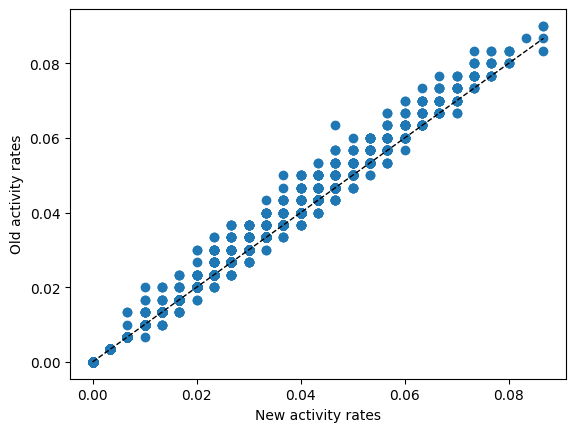

In [57]:
import matplotlib.pyplot as plt
plt.plot([0.0, act_new.mean(0).max()], [0.0, act_new.mean(0).max()], color='black', linestyle='--', linewidth=1)
plt.scatter(act_new.mean(0).flatten(), act_old.mean(0).flatten())
plt.xlabel('New activity rates')
plt.ylabel('Old activity rates')
plt.show()

## 2) Accuracy on the whole dataset

In [59]:
import tonic
import tqdm

In [60]:
bs = 128
collate = tonic.collation.PadTensors(batch_first=False)
to_frame = tonic.transforms.ToFrame(
    sensor_size=tonic.datasets.NMNIST.sensor_size, time_window=1e3
)
test_ds = tonic.datasets.NMNIST("./nmnist", transform=to_frame, train=False)
test_dl = torch.utils.data.DataLoader(
    test_ds, shuffle=True, batch_size=bs, collate_fn=collate
)

accuracies = []
pbar = tqdm.tqdm(total=len(test_dl), desc="Processing", position=0, leave=True)
for idx, (x, y) in enumerate(test_dl):
    # x = torch.moveaxis(x, 0, -1)

    # reset/init I&F neurons
    mem_dict = {}
    for idx, module in enumerate(modules):
        if isinstance(module, snn.Leaky):
            mem_dict[idx] = module.init_leaky()

    # forward pass through time
    out = []
    for t in range(x.shape[0]):
        xt = x[t]
        for idx, module in enumerate(modules):
            if isinstance(module, snn.Leaky):
                xt, mem_dict[idx] = module(xt, mem_dict[idx])
            elif isinstance(module, nn.Flatten):
                xt = xt.flatten(1, -1)
            else:
                xt = module(xt)
        out.append(xt)
    out = torch.stack(out).detach()

    pred = out.mean(0).argmax(-1)
    accuracy = (pred == y).sum() / x.shape[1]
    accuracies.append(accuracy)
    pbar.set_postfix(accuracy="{:.2f}%".format(sum(accuracies) / len(accuracies) * 100))
    pbar.update(1)
pbar.close()
accuracies = np.array(accuracies)
print(f"accuracy: {accuracies.mean():.2%} +/- {accuracies.std():.2%}")
np.save("snntorch_accuracies.npy", accuracies)
np.save("snntorch_accuracy.npy", accuracies.mean())

Processing: 100%|██████████| 79/79 [06:56<00:00,  5.28s/it, accuracy=97.85%]

accuracy: 97.85% +/- 1.83%


In [61]:
old_accuracy = np.load("snnTorch_accuracy_old.npy")
print(f"Old accuracy: {old_accuracy:.2%}")
print(f"New accuracy: {accuracies.mean():.2%}")

Old accuracy: 97.90%
New accuracy: 97.85%
